# NASNETLARGE

In [4]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [5]:
train_frame_folder = 'train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
cnt = 0
for vid in list_of_train_data:
    print("{} {}".format(vid, cnt))
    cnt += 1
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('ds1/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (224, 224)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('ds1/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (224, 224)))
                count+=1

aagfhgtpmv.mp4 0
aapnvogymq.mp4 1
abarnvbtwb.mp4 2
abofeumbvv.mp4 3
abqwwspghj.mp4 4
acifjvzvpm.mp4 5
acqfdwsrhi.mp4 6
acxnxvbsxk.mp4 7
acxwigylke.mp4 8
aczrgyricp.mp4 9
adhsbajydo.mp4 10
adohikbdaz.mp4 11
adylbeequz.mp4 12
aelfnikyqj.mp4 13
aelzhcnwgf.mp4 14
aettqgevhz.mp4 15
aevrfsexku.mp4 16
afoovlsmtx.mp4 17
agdkmztvby.mp4 18
agqphdxmwt.mp4 19
agrmhtjdlk.mp4 20
ahbweevwpv.mp4 21
ahdbuwqxit.mp4 22
ahfazfbntc.mp4 23
ahqqqilsxt.mp4 24
aipfdnwpoo.mp4 25
ajqslcypsw.mp4 26
ajwpjhrbcv.mp4 27
aklqzsddfl.mp4 28
aknbdpmgua.mp4 29
aknmpoonls.mp4 30
akvmwkdyuv.mp4 31
akxoopqjqz.mp4 32
akzbnazxtz.mp4 33
aladcziidp.mp4 34
alaijyygdv.mp4 35
alninxcyhg.mp4 36
altziddtxi.mp4 37
alvgwypubw.mp4 38
amaivqofda.mp4 39
amowujxmzc.mp4 40
andaxzscny.mp4 41
aneclqfpbt.mp4 42
anpuvshzoo.mp4 43
aorjvbyxhw.mp4 44
apatcsqejh.mp4 45
apgjqzkoma.mp4 46
apogckdfrz.mp4 47
aqpnvjhuzw.mp4 48
arkroixhey.mp4 49
arlmiizoob.mp4 50
arrhsnjqku.mp4 51
asaxgevnnp.mp4 52
asdpeebotb.mp4 53
aslsvlvpth.mp4 54
asmpfjfzif.mp4 55
as

# MODEL

In [10]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [11]:
input_shape = (224, 224, 3)
data_dir = 'ds'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 224, 224, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [12]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = NASNetMobile(include_top=False, weights="imagenet", input_shape = input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d_3   (None, 1056)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 2114      
                                                                 
Total params: 4,271,830
Trainable params: 4,235,092
Non-trainable params: 36,738
_________________________________________________________________


In [13]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
12/12 [==============================] - 954s 72s/step - loss: 0.6842 - accuracy: 0.5938 - val_loss: 0.8128 - val_accuracy: 0.4714
Epoch 2/20
12/12 [==============================] - 975s 81s/step - loss: 0.6403 - accuracy: 0.6812 - val_loss: 0.8101 - val_accuracy: 0.4714
Epoch 3/20
12/12 [==============================] - 859s 72s/step - loss: 0.6052 - accuracy: 0.7411 - val_loss: 0.8080 - val_accuracy: 0.4750
Epoch 4/20
12/12 [==============================] - 878s 73s/step - loss: 0.5748 - accuracy: 0.7857 - val_loss: 0.8079 - val_accuracy: 0.4714
Epoch 5/20
12/12 [==============================] - 873s 72s/step - loss: 0.5431 - accuracy: 0.8232 - val_loss: 0.8082 - val_accuracy: 0.4714
Epoch 6/20
12/12 [==============================] - 838s 70s/step - loss: 0.5136 - accuracy: 0.8509 - val_loss: 0.8081 - val_accuracy: 0.4714
Epoch 7/20
12/12 [==============================] - 766s 63s/step - loss: 0.4826 - accuracy: 0.8786 - val_loss: 0.8096 - val_accuracy: 0.4714
Epoch 

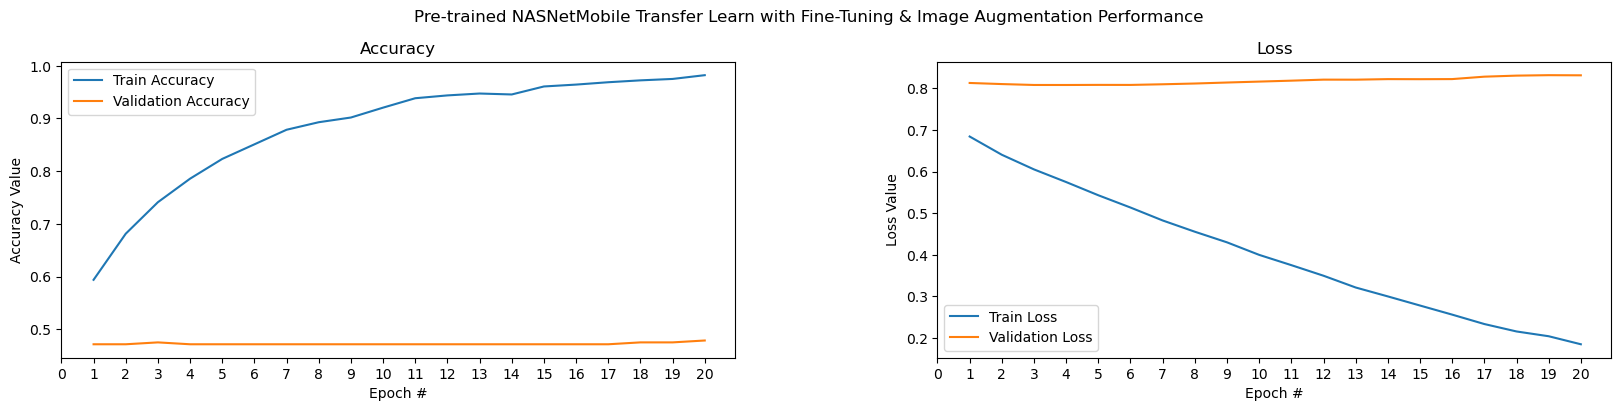

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained NASNetMobile Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

44/44 [==============================] - 59s 1s/step
True positive =  12
False positive =  688
False negative =  0
True negative =  700




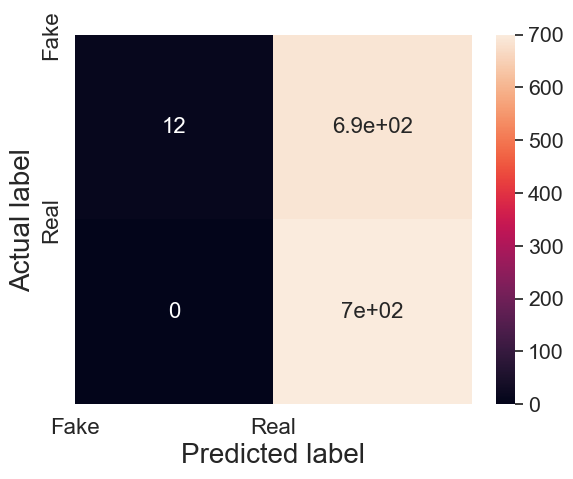

In [15]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
predict_x=model.predict(X) 
classes_x=np.argmax(predict_x,axis=1)

print_confusion_matrix(Y_val_org, classes_x)

In [16]:
model.save('deepfake-detection-model-nasnetmobile.h5')